In [1]:
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import sklearn.metrics as metrics

sns.set()

**Model Pipeline**

* **1. Reading data** - read sample data
* **2. Cleaning and normalisation** - clean and normalise input data
* **3. Correlations** - calculate and visualise correlations
* **4. Feature importance** - calculate and visualise feature importance
* **5. Model fitting** - fit linear model
* **6. Prediction** - perform out-of-sample prediction


### 1. Read in sales and media spend data

In [92]:
input_data = 'data/mmm_sample_data.csv'
mmm_df = pd.read_csv(input_data)

mmm_df.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


### 2. Clean and normalise input data

In [93]:
mmm_df.drop(['Unnamed: 0'],axis=1, inplace=True)
mmm_df.describe()
mmm_df['week_index'] = mmm_df.index

In [94]:
def add_week(row):
    start_date = datetime.strptime("2017-01-02","%Y-%m-%d")
    row['date'] = timedelta(row['week_index']*7) + start_date
    return row
mmm_df = mmm_df.apply(lambda row: add_week(row), axis=1)
mmm_df.drop('week_index', axis=1, inplace=True)

In [95]:
mmm_df

,TV,radio,newspaper,sales,date
0,230.1,37.8,69.2,22.1,2017-01-02
1,44.5,39.3,45.1,10.4,2017-01-09
2,17.2,45.9,69.3,9.3,2017-01-16
3,151.5,41.3,58.5,18.5,2017-01-23
4,180.8,10.8,58.4,12.9,2017-01-30
...,...,...,...,...,...
195,38.2,3.7,13.8,7.6,2020-09-28
196,94.2,4.9,8.1,9.7,2020-10-05
197,177.0,9.3,6.4,12.8,2020-10-12
198,283.6,42.0,66.2,25.5,2020-10-19


In [96]:
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()
mmm_df[['TV', 'radio', 'newspaper']] = input_scaler.fit_transform(mmm_df[['TV', 'radio', 'newspaper']])
mmm_df['sales'] = output_scaler.fit_transform(np.array(mmm_df['sales']).reshape(-1,1))
mmm_df

,TV,radio,newspaper,sales,date
0,0.775786,0.762097,0.605981,0.807087,2017-01-02
1,0.148123,0.792339,0.394019,0.346457,2017-01-09
2,0.055800,0.925403,0.606860,0.303150,2017-01-16
3,0.509976,0.832661,0.511873,0.665354,2017-01-23
4,0.609063,0.217742,0.510994,0.444882,2017-01-30
...,...,...,...,...,...
195,0.126818,0.074597,0.118734,0.236220,2020-09-28
196,0.316199,0.098790,0.068602,0.318898,2020-10-05
197,0.596212,0.187500,0.053650,0.440945,2020-10-12
198,0.956713,0.846774,0.579595,0.940945,2020-10-19


### 3. Calculate and visualise the correlations

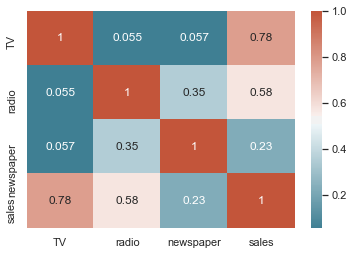

In [97]:
corr = mmm_df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

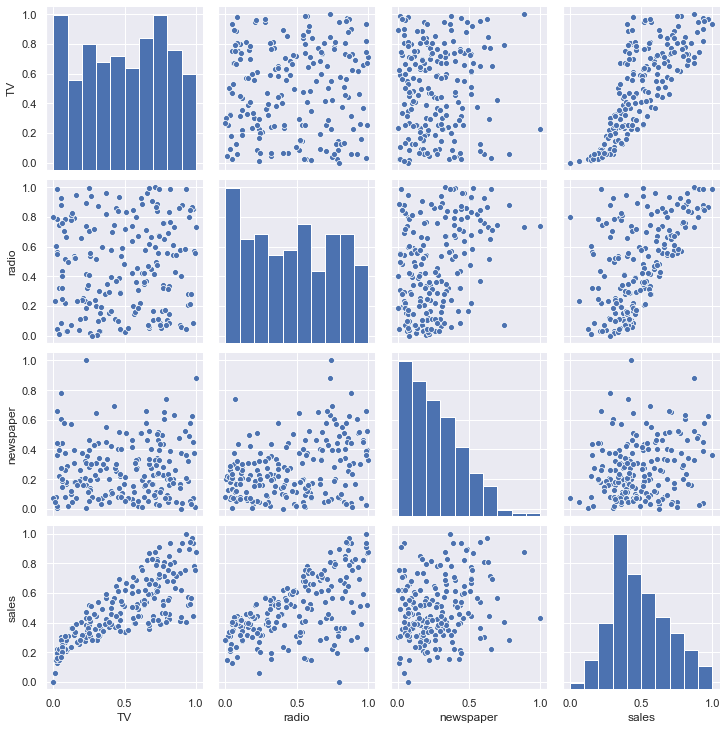

In [98]:
# TV spend has the highest correlation with sales
# Let's also visualise the variable interaction using pair plots 
sns.pairplot(mmm_df)

### 4. Calculate and visualise feature importance

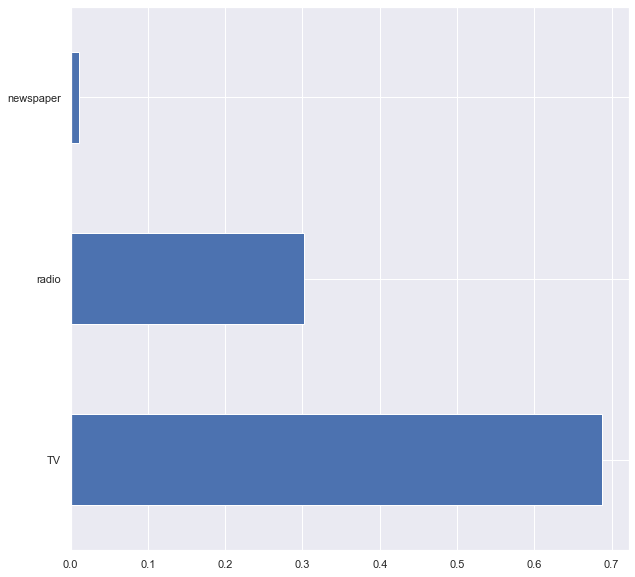

In [99]:
# Setting X and y variables, remove sales from the independent variable set
X = mmm_df.loc[:, (mmm_df.columns != 'sales')&(mmm_df.columns != 'date')]
y = mmm_df['sales']
X_train = X[:int(X.shape[0]*.8)]
X_test = X[int(X.shape[0]*.8):]
y_train = y[:int(X.shape[0]*.8)]
y_test = y[int(X.shape[0]*.8):]
# Building Random Forest model
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
# Visualizing Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

### 5. Fit Linear Model

### 6. Perform Out of Sample Prediction

In [101]:
y_pred = model.predict(X_test)
y_pred = output_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = output_scaler.inverse_transform(np.array(y_test).reshape(-1, 1))

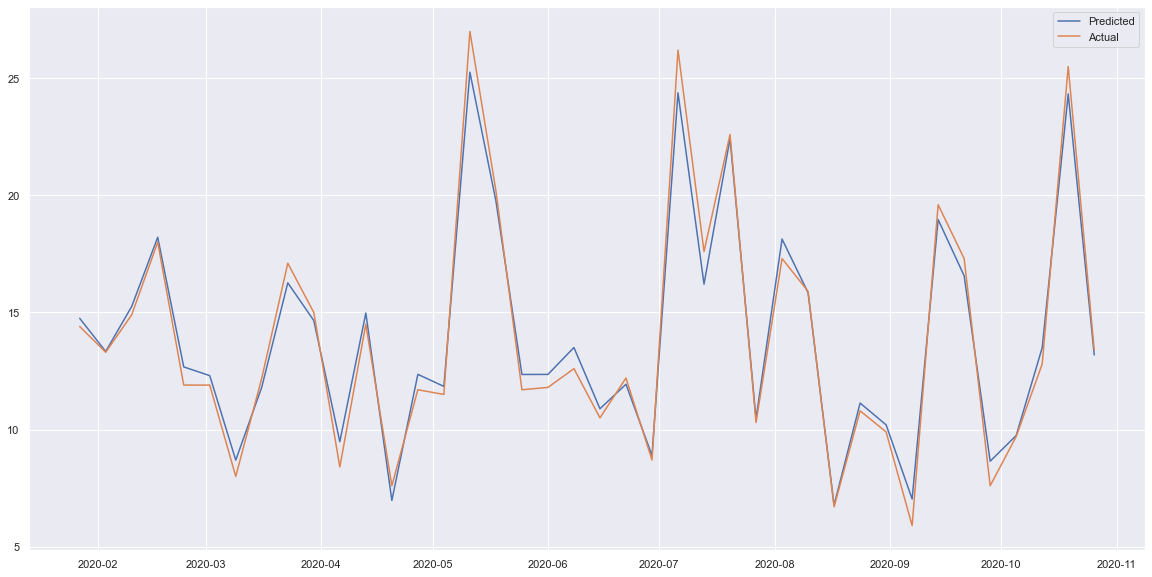

In [106]:
plt.figure(figsize=(20, 10))
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], y_pred, label = 'Predicted')
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], y_test, label = 'Actual')
plt.legend()

In [108]:
metrics.mean_squared_error(y_test, y_pred)

0.5331137250000008

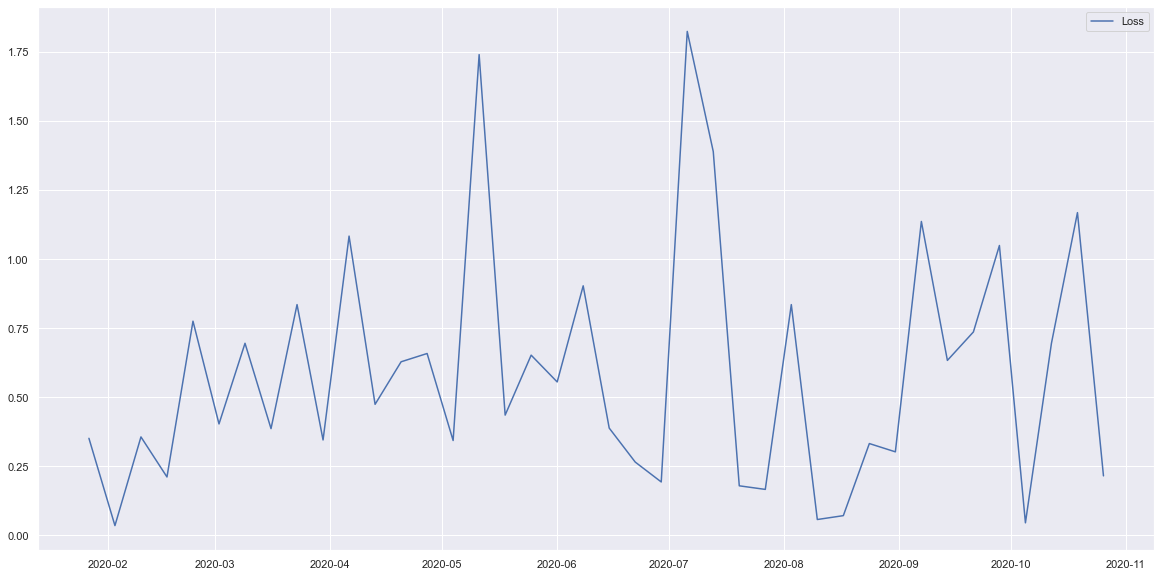

In [113]:
plt.figure(figsize=(20, 10))
plt.plot(mmm_df['date'][int(int(mmm_df.shape[0]*.8)):], np.sqrt((y_test-y_pred)**2), label = 'Loss')
plt.legend()